## Overview

This notebook explores death by time of year using the 2014 CDC mortality dataset found on [Kaggle](https://www.kaggle.com/cdc/mortality). Initially, deaths by month of the year and by manner of death are explored.

In [1]:
# import relevant libraries

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sqlalchemy as sqla

In [2]:
# Connect to SQLite database found in data/database.sqlite

metadata = sqla.MetaData()

engine =  sqla.create_engine("sqlite:///data/database.sqlite")

table_names = engine.table_names()

tables = dict()

for table in table_names:
    tables[table] = sqla.Table(table, metadata, autoload=True, autoload_with=engine)

count        12.00000
mean     219264.25000
std       13344.62626
min      205058.00000
25%      209417.50000
50%      216599.50000
75%      223523.00000
max      243839.00000
Name: Number of Deaths, dtype: float64


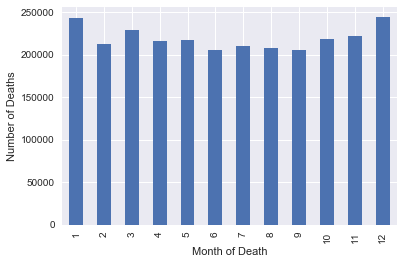

In [3]:
%matplotlib inline

# Connect to engine

conn = engine.connect()

# Generate statement
stmt = sqla.select([tables["DeathRecords"].columns.MonthOfDeath, 
                    sqla.func.count(tables["DeathRecords"].columns.MonthOfDeath).label('Number of Deaths')])

stmt = stmt.group_by(tables["DeathRecords"].columns.MonthOfDeath)

count = pd.read_sql_query(stmt, conn)

print(count['Number of Deaths'].describe())

count.plot(x = 'MonthOfDeath', y = 'Number of Deaths', kind = 'bar', legend=False)
plt.xlabel("Month of Death")
plt.ylabel("Number of Deaths")

The graph shown here suggests that the number of deaths is highest in December (12) and January (1), perhaps due to suicides from seasonal affective disorder or the stress of the holidays. To see if this might be the case, we query the database again except this time counting each manner of death.

(0, 425000)

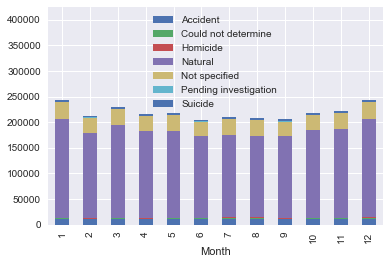

In [4]:
%matplotlib inline
# Generate new SQL query using a JOIN

# Create initial select query
stmt = sqla.select([
    tables["DeathRecords"].c.MonthOfDeath.label('Month'),
    sqla.func.count(tables["DeathRecords"].c.MannerOfDeath).label('Number'),
    tables["MannerOfDeath"].c.Description.label('Manner')
])

# Create select from with JOIN statment

stmt = stmt.select_from(
    tables["DeathRecords"].join(tables["MannerOfDeath"], 
                               tables["DeathRecords"].c.MannerOfDeath == tables["MannerOfDeath"].c.Code)
)

# Group by Month and Manner of Death

stmt = stmt.group_by(tables["DeathRecords"].c.MonthOfDeath,
                    tables["MannerOfDeath"].c.Description)

count = pd.read_sql_query(stmt, conn)

count_grouped = count.groupby(['Month', 'Manner'])['Number'].sum().unstack('Manner')

fig, ax = plt.subplots(1)

count_grouped.plot.bar(stacked=True, ax = ax)

ax.legend(loc='best')
ax.set_ylim([0, 425000])

Most of the deaths in any given month are from natural causes, so suicides may not be the cause of the observed seasonal pattern. To confirm, we plot both suicides and natural causes in separate plots.

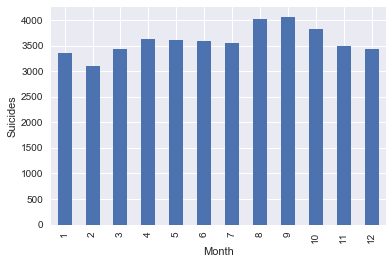

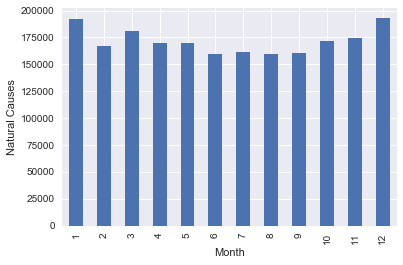

In [5]:
%matplotlib inline


_ = count[count['Manner'] == 'Suicide'].plot.bar(x = 'Month', legend=False)
_.set_ylabel("Suicides")

_ = count[count['Manner'] == 'Natural'].plot.bar(x = 'Month', legend=False)
_.set_ylabel("Natural Causes")

It appears that compared to our initial guess, suicides are actually more common in August (8) and September(9). What then, is driving the seasonal trend in deaths by natural causes?

## Seasonal trends in natural causes

To better understand what may drive the seasonal trend in natural deaths, we can use the cause of death binned into 39 fields [CauseRecode39](https://www.cdc.gov/nchs/data/dvs/Record_Layout_2014.pdf) to get a better idea of what types of deaths may vary with month. Most of the bins relate to natural causes such as Tuberculosis and Cardiovascular Disease, although vehicle accidents, murders, and suicides are also included. We use these to select the ICD-10 codes for the cause of death to narrow down the number of possible causes to the major causes of death. Unfortunately, there is no look up table for the rebinned death causes, so we must insert these manually with pandas.


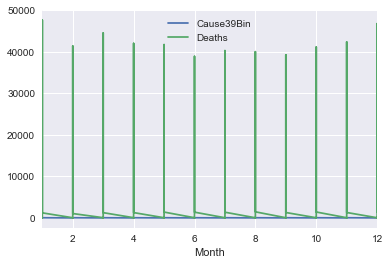

In [17]:
%matplotlib inline

# Build SQL query

stmt = sqla.select([
    tables["DeathRecords"].c.MonthOfDeath.label('Month'),
    tables["DeathRecords"].c.CauseRecode39.label('Cause39Bin'),
    tables["DeathRecords"].c.Icd10Code.label("ICD-10"),
    tables["Icd10Code"].c.Description.label('Cause'),
    sqla.func.count(tables["DeathRecords"].c.CauseRecode39).label('Deaths')
                    ])

# Select from table JOIN

stmt = stmt.select_from(
    tables["DeathRecords"].join(tables["Icd10Code"],
                               tables["DeathRecords"].c.Icd10Code == tables["Icd10Code"].c.Code)
                        )

# Remove other causes

stmt = stmt.where(tables["DeathRecords"].c.CauseRecode39 != 42)

# Group by Month and Cause39Bin

stmt = stmt.group_by(tables["DeathRecords"].c.MonthOfDeath, tables["DeathRecords"].c.CauseRecode39)

count = pd.read_sql_query(stmt, conn)

#count_grouped = count.groupby(['Month', 'Cause39Bin'])['Deaths'].sum().unstack('Month')

fig, ax = plt.subplots(1)

count.plot.line(x = 'Month', ax = ax)

ax.legend(loc='best')